In [25]:
from pysme.linelist.linelist import LineList
from pysme.linelist.vald import ValdFile
from pysme.sme import SME_Structure
from pysme.solve import solve
from pysme.abund import Abund
from pysme import sme as SME
from pysme import util 

from pysme.synthesize import synthesize_spectrum
from astropy.constants import c
from pysme.util import vac2air

from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import sys
import os

warnings.filterwarnings('ignore')

In [26]:
os.chdir('/home/fgran/iSpec/')
import ispec
sys.path.append('/home/fgran/iSpec/')

In [27]:
#Move to the correct directory: Pristine-UVES
os.chdir('/store/teams/cosmos/fgran/data/Pristine-UVES/')

In [28]:
os.environ['NUMEXPR_MAX_THREADS'] = '80' #change this number using the correct number of cores/threads in jupyter.slurm

In [29]:
#Prepare catalogue ingestion

In [30]:
uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe_c_corr.csv')

In [31]:
uves.head(2)

,source_id,ebv,g0,eg,bp0,ebp,rp0,erp,cahk0,ecahk,...,evmac_nlte_fit,sme_nlte_vrad1,sme_nlte_vrad2,sme_nlte_vrad3,c,ec_sme,ec_fit,is_limit_c,niter_c,carbon_correction_03
0,1166634514845213568,0.034659,11.670373,0.002767,12.097350,0.002867,11.063974,0.003820,13.051166,0.009495,...,0.091985,0.085946,0.066876,-0.149777,8.350304,0.158630,0.005421,False,13,0.45
1,1172165023972931072,0.026574,12.876005,0.002772,13.314315,0.003091,12.258079,0.003841,14.291629,0.016091,...,0.079677,0.068610,0.068886,-0.103765,8.342535,0.164282,0.007953,False,13,0.19


In [32]:
#pysme that only need to be executed once
# linelist_short_all = ValdFile('linelist/3800-6800_short.lin')
linelist = ValdFile('linelist/VALD_korg_linelist_3000_9000.lin', medium='air')
linelist.wlcent = vac2air(linelist.wlcent, 'A')

# linelist_short_all = linelist_short_all[linelist_short_all.depth > 0.1]
print('Number of lines in the linelist: %d' %linelist.species.size)

delta_H_line = 10. #AA
delta_line = 0.75 #AA
wl_G_band = 4300 #AA
delta_G_band = 40. #AA

wl_Halpha_line = 6562.79 #AA
delta_Halpha = 1.0 #AA
wl_Hbeta_line = 4861.35 #AA
delta_Hbeta = 0.75 #AA

[2024-11-14 18:02:56,676] [INFO] [vald:loads:173]: Loading VALD file linelist/VALD_korg_linelist_3000_9000.lin


INFO - Loading VALD file linelist/VALD_korg_linelist_3000_9000.lin


[2024-11-14 18:02:57,205] [WARNING] [vald:parse_references:530]: Could not find citation key: FBHM
[2024-11-14 18:02:57,207] [DEBUG] [vald:parse_references:531]: 'fbhm'


WARNING - Could not find citation key: FBHM
Number of lines in the linelist: 41861


In [33]:
wmin_blue = 3700 # 4000 #AA
wmax_blue = 4500 #AA

In [34]:
#Create solar scaled atmosphere with [alpha/Fe] = +0.4
solar = SME_Structure()
solar.abund = Abund(0.0, 'asplund2009')

abund = solar.abund.pattern
abund['O'] = abund['O'] + 0.4
abund['Ne'] = abund['Ne'] + 0.4
abund['Mg'] = abund['Mg'] + 0.4
abund['Si'] = abund['Si'] + 0.4
abund['S'] = abund['S'] + 0.4
abund['Ar'] = abund['Ar'] + 0.4
abund['Ca'] = abund['Ca'] + 0.4
abund['Ti'] = abund['Ti'] + 0.4

In [35]:
%%time
#Read isochrones
basti = pd.read_hdf('iso/BaSTI_GDR3_2MASS_WISE_All_ages_afe=0.4.h5', key='table')

CPU times: user 4.77 s, sys: 3 s, total: 7.77 s
Wall time: 53.8 s


In [36]:
uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe_c_corr.csv')

In [37]:
uves['cfe'] = uves.c.values - solar.abund.get_element('C')
uves['cfe_corr'] = uves.c.values - solar.abund.get_element('C') + uves.carbon_correction_03.values

In [38]:
from matplotlib.colorbar import Colorbar
import matplotlib.gridspec as gridspec

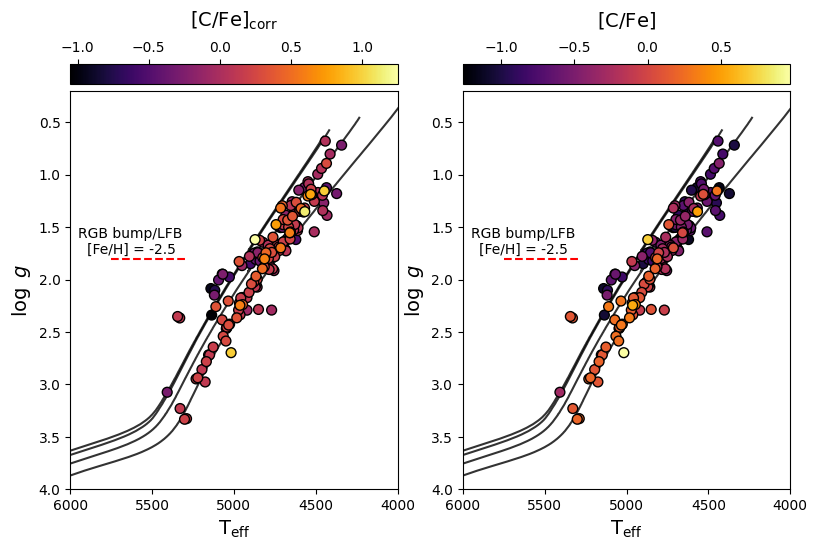

In [39]:
fig = plt.figure(1, figsize=(8,5), dpi=100)

gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[0.05, 1], width_ratios=[1,1])
gs.update(left=0.05, right=0.95, bottom=0.08, top=0.93, wspace=0.2, hspace=0.03)


ax1 = plt.subplot(gs[1,0])
plt1 = ax1.scatter(uves.sort_values(by='cfe_corr', ascending=True).teff.values, uves.sort_values(by='cfe_corr', ascending=True).logg.values, 
            c=uves.sort_values(by='cfe_corr', ascending=True).cfe_corr.values, ec='k', cmap=plt.cm.inferno, s=50)
cb = plt.subplot(gs[0,0])
cb = Colorbar(ax=cb, mappable=plt1, orientation='horizontal', ticklocation='top', )
cb.set_label(r'${\rm [C/Fe]_{\rm corr}}$', size=14, labelpad=10)

n = 1290
for age, meta in np.vstack(([[12.0, 12.0, 12.0, 12.0], [-1.5, -2.0, -2.5, -3.0]])).T:
    iso = basti[(basti.age.values == age) & (basti.meta.values == meta)]
    iso = iso[iso.reset_index().index < n]
    ax1.plot(iso.Teff.values, iso.logg.values, color='k', zorder=0, alpha=0.8)

ax1.text(x=5950, y=1.6, s=r'RGB bump/LFB')
ax1.text(x=5900, y=1.75, s=r'[Fe/H] = -2.5')
ax1.hlines(1.8, 5750, 5300, color='r', ls='--')

ax1.set_ylim(4.0, 0.2)
ax1.set_xlim(6000, 4000)
ax1.set_xlabel(r'T$_{\rm eff}$', size=14)
ax1.set_ylabel(r'$\log\ g$', size=14)


ax2 = plt.subplot(gs[1,1])
plt2 = ax2.scatter(uves.sort_values(by='cfe', ascending=True).teff.values, uves.sort_values(by='cfe', ascending=True).logg.values, 
            c=uves.sort_values(by='cfe', ascending=True).cfe.values, ec='k', cmap=plt.cm.inferno, s=50)
cb = plt.subplot(gs[0,1])
cb = Colorbar(ax=cb, mappable=plt2, orientation='horizontal', ticklocation='top')
cb.set_label(r'${\rm [C/Fe]}$', size=14, labelpad=10)

n = 1290
for age, meta in np.vstack(([[12.0, 12.0, 12.0, 12.0], [-1.5, -2.0, -2.5, -3.0]])).T:
    iso = basti[(basti.age.values == age) & (basti.meta.values == meta)]
    iso = iso[iso.reset_index().index < n]
    ax2.plot(iso.Teff.values, iso.logg.values, color='k', zorder=0, alpha=0.8)

ax2.text(x=5950, y=1.6, s=r'RGB bump/LFB')
ax2.text(x=5900, y=1.75, s=r'[Fe/H] = -2.5')
ax2.hlines(1.8, 5750, 5300, color='r', ls='--')

ax2.set_ylim(4.0, 0.2)
ax2.set_xlim(6000, 4000)
ax2.set_xlabel(r'T$_{\rm eff}$', size=14)
ax2.set_ylabel(r'$\log\ g$', size=14)

# plt.tight_layout()
plt.savefig('plots/Carbon_Kiel.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [40]:
uves['logL'] = np.log10(0.8/1.0) + 4*np.log10(uves.teff.values/5780.) - uves.logg.values + 4.44

In [41]:
#Search for L_bump at low metallicity according to BaSTI
# uves.query('logg > 1.75 and logg < 1.85').logL.mean()
L_bump = 1.8

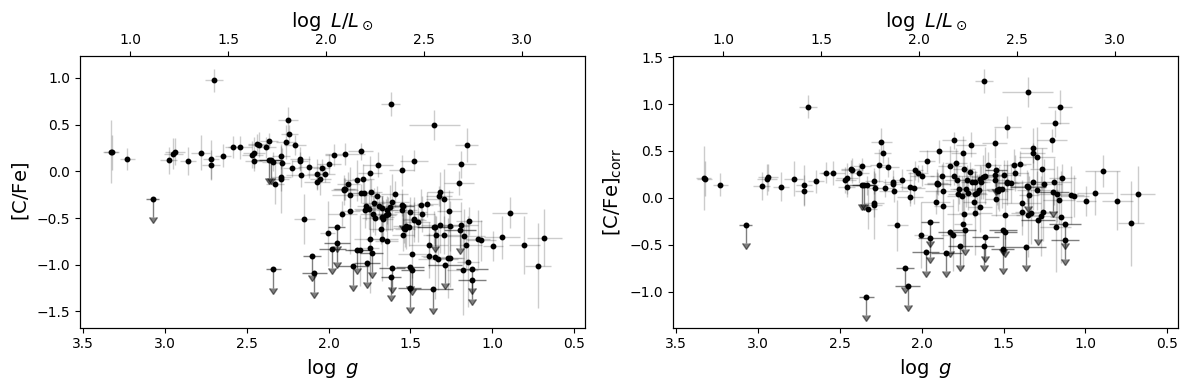

In [307]:
plt.figure(figsize=(12,4), dpi=100)

plt.subplot(1,2,1)
plt.scatter(uves.logg.values, uves.cfe.values, color='k', s=10)

f_c = (uves.ec_sme.values < 0.5)
plt.errorbar(uves.logg.values[f_c], uves.cfe.values[f_c], fmt='k.', 
             xerr=uves.elogg_sme.values[f_c], yerr=uves.ec_sme.values[f_c], lw=1, alpha=0.2)
plt.errorbar(uves.logg.values[~f_c], uves.cfe.values[~f_c], fmt='k.', 
             xerr=uves.elogg_sme.values[~f_c], yerr=0.2*np.ones_like(uves.c.values[~f_c]), lw=1, alpha=0.5, uplims=np.ones_like(uves.c.values, dtype=bool)[~f_c])
plt.gca().invert_xaxis()

plt.ylabel(r'${\rm [C/Fe]}$', size=14)
plt.xlabel(r'$\log\ g$', size=14)

plt.twiny()
plt.scatter(uves.logL.values, uves.cfe.values, s=0)
# plt.plot(denissenkov04.logL.values, denissenkov04.cfe.values)
plt.xlabel(r'$\log\ L/L_\odot$', size=14)
# plt.plot(np.linspace(0.4, 0.8), 3-np.linspace(0.4, 0.8))

plt.subplot(1,2,2)
plt.scatter(uves.logg.values, uves.cfe_corr.values, color='k', s=10)

f_c = (uves.ec_sme.values < 0.5)
plt.errorbar(uves.logg.values[f_c], uves.cfe_corr.values[f_c], fmt='k.', xerr=uves.elogg_sme.values[f_c], yerr=uves.ec_sme.values[f_c], lw=1, alpha=0.2)
plt.errorbar(uves.logg.values[~f_c], uves.cfe_corr.values[~f_c], fmt='k.', xerr=uves.elogg_sme.values[~f_c], 
             yerr=0.2*np.ones_like(uves.c.values[~f_c]), lw=1, alpha=0.5, uplims=np.ones_like(uves.c.values, dtype=bool)[~f_c])
plt.gca().invert_xaxis()

plt.ylabel(r'${\rm [C/Fe]_{\rm corr}}$', size=14)
plt.xlabel(r'$\log\ g$', size=14)

plt.twiny()
plt.scatter(uves.logL.values, uves.cfe_corr.values, s=0)
plt.xlabel(r'$\log\ L/L_\odot$', size=14)

# plt.hlines(0.3, 1.0, 3.0)

plt.tight_layout()
plt.savefig('plots/Carbon_logg_LogL.pdf', dpi=300)
plt.show()

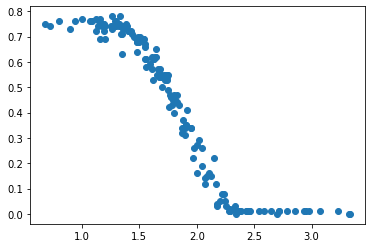

In [43]:
plt.scatter(uves.logg.values, uves.carbon_correction_03.values)
plt.show()

In [44]:
wmin_blue = 4229.5 #AA
wmax_blue = 4232.2 #AA

In [48]:
linelist = pd.DataFrame(ValdFile('linelist/CH_VALD_all.lin'))

#Carbon scaled to metal-poor
c12_factor, c13_factor = 1.0, 1.0
linelist.gflog[linelist.reference.str.contains('(12)CH')] = np.log10(c12_factor * 10**linelist.gflog.values)
linelist.gflog[linelist.reference.str.contains('(13)CH')] = np.log10(c13_factor * 10**linelist.gflog.values)

linelist = linelist[(linelist.wlcent.values > wmin_blue) & (linelist.wlcent.values < wmax_blue)]

linelist = LineList(linelist)

[2024-11-14 18:05:53,766] [INFO] [vald:loads:173]: Loading VALD file linelist/CH_VALD_all.lin


INFO - Loading VALD file linelist/CH_VALD_all.lin


In [49]:
mask_cont = pd.read_csv('continuum_model/sme_cont_mask_blue', delim_whitespace=True, names=['wl', 'mask_values'])

In [173]:
#SME parallel and limits functions

In [174]:
def limits(species = 'C', species_to_keep = [], spec_id = '', sme_file = '', wlmin = 0, wlmax = 0, start = -2.0, stop = 2.0, step = 0.25):
    
    # plt.figure(figsize=(7,7), dpi=100)
    
    util.start_logging('logs/elems_limits.dat', level='WARNING')
    species = 'C'
    limit = solar.abund.get_element('%s' %species)
    # start, stop, step = -2.0, 2.0, 0.25

    for delta_abund in np.linspace(start, stop, int((stop - start) / step + 1)):

        synth = SME_Structure.load(sme_file)
        # if delta_abund == start: print(synth.abund.get_element('C'))
        # if delta_abund == start: plt.step(synth.wave.data, synth.synth.data, lw=1, color='r')
        synth.linelist = linelist[(linelist.wlcent > wlmin) & (linelist.wlcent < wlmax)]

        f_wl_limit = (synth.wave.data > wlmin) & (synth.wave.data < wlmax)

        for elem in synth.abund.pattern.keys():
            if (elem == 'H') or (elem == 'He'):
                continue
            if elem in species_to_keep:
                continue
            synth.abund.update_pattern({elem:0.0})
        synth.abund.update_pattern({'%s' %species: solar.abund.get_element('%s' %species) + delta_abund})
        # print('%s' %species, solar.abund.get_element('%s' %species) + delta_abund)

        synth.vrad_flag = 'None'
        synth.cscale_flag = 'None'
        synth = synthesize_spectrum(synth)
        # synth_data = synth.synth.data

        mean_synth = np.percentile(synth.synth.data[f_wl_limit], 10)
        std_spec = np.std(synth.spec.data[f_wl_limit])
        
        # if delta_abund == start: plt.step(synth.wave.data, synth.spec.data, lw=1, color='k')
        # if delta_abund == start: plt.hlines(1.-std_spec, wlmin, wlmax, color='b', lw=1, ls='--')
        # plt.step(synth.wave.data, synth.synth.data, lw=1, color='g', alpha=0.2)
        # plt.hlines(mean_synth, wlmin, wlmax, color='r', lw=1, ls='--', alpha=0.3)
        # plt.xlim(wlmin, wlmax)

        #If mean synth flux is more (bigger depth) that std: you are in outside limit regime
        #linspace in the starst is fliped to ascend in abundance space
        if mean_synth < (1. - std_spec):
            limit = solar.abund.get_element('%s' %species) + delta_abund - step/2.
            # plt.show()
            return limit
        else:
            continue
    # plt.show()
    return limit

In [175]:
def sme_parallel(i, input_row, elems_to_include, elem_string, tol=1e-8):
    
    #Create SME structures
    sme = SME_Structure()

    sme.ipres, sme.iptype, sme.gam6, sme.h2broad = 42000, 'gauss', True, True

    sme.atmo.source, sme.atmo.method, sme.atmo.geom = 'marcs2012s_t2.0.sav', 'grid', 'SPH'

    sme.accxt, sme.accgt, sme.accft = tol, tol, tol
    sme.leastsquare3_ftol, sme.leastsquares_gtol, sme.leastsquares_xtol = tol, tol, tol
    sme.accwi, sme.accrt, sme.clim, sme.chirat = tol, tol, tol, tol    
    sme.vrad_bounds = -5., 5.

    sme.cscale_flag = 'constant'
    sme.cscale = 1.0
    # sme.cscale_type = 'mcmc' #'mcmc'
    sme.fitresults.maxiter = 50

    # Redirect output to logs/RUN*/*.txt
    util.start_logging(log_file='logs/cfe_ratio_run.txt', level='ERROR')

    #Reading norm specta from files
    blue_spec = ispec.read_spectrum('norm_RV_corr/%s/blue_%s' %(input_row.run, input_row.blue_file))
    blue_spec.waveobs = blue_spec.waveobs * 10.

    sme.wave = blue_spec.waveobs[(blue_spec.waveobs > wmin_blue) & (blue_spec.waveobs < wmax_blue)]
    sme.spec = blue_spec.flux[(blue_spec.waveobs > wmin_blue) & (blue_spec.waveobs < wmax_blue)]
    sme.uncs = blue_spec.err[(blue_spec.waveobs > wmin_blue) & (blue_spec.waveobs < wmax_blue)]
    del blue_spec

    sme.mask = np.ones_like(sme.wave).astype(int)

    if elem_string == '12C': f_c = pd.DataFrame(linelist).reference.str.contains('\(12\)CH').values
    if elem_string == '13C': f_c = pd.DataFrame(linelist).reference.str.contains('\(13\)CH').values

    if (elem_string == '12C') | (elem_string == '13C'):
        sme.linelist = linelist[(linelist.wlcent > np.min(sme.wave.data)) & (linelist.wlcent < np.max(sme.wave.data)) & f_c].sort()
    else:
        sme.linelist = linelist[(linelist.wlcent > np.min(sme.wave.data)) & (linelist.wlcent < np.max(sme.wave.data))].sort()
    # del ll_mask

    #Abundance scaling to create realistic synthetics
    sme.abund = abund
    #RV determination for each chip
    sme.vrad_flag = 'fix'

    #input guesses from SME
    sme.teff = input_row.teff
    sme.logg = input_row.logg
    sme.monh = input_row.monh
    sme.vmic = input_row.vmic
    sme.vmac = input_row.vmac_fe
    sme.vrad = input_row.sme_vrad1

    sme.abund.update_pattern({'Fe':input_row.fe})
    sme.abund.update_pattern({'C':input_row.c + input_row.monh})
    
    #NLTE grids
    # sme.nlte.set_nlte('Fe', 'nlte_Fe_ama51_Feb2022_pysme.grd')
    # sme.nlte.set_nlte('C', 'nlte_C_ama51_pysme.grd')

    fitparameters = ['abund C']

    #Do the heavy lifting
    sme = solve(sme, fitparameters)

    if (sme.fitresults.iterations == 1) | (sme.fitresults.values > 10.):
        tol = 1e-14
        sme.accxt, sme.accgt, sme.accft = tol, tol, tol
        sme.leastsquare3_ftol, sme.leastsquares_gtol, sme.leastsquares_xtol = tol, tol, tol
        sme.accwi, sme.accrt, sme.clim, sme.chirat = tol, tol, tol, tol  
        sme = solve(sme, fitparameters)
    
    if elem_string == '12C':
        c12, ec12_sme, ec12_fit = sme.fitresults.values[0], sme.fitresults.uncertainties[0], sme.fitresults.fit_uncertainties[0]
        data_to_write = np.vstack((input_row.spec_id, c12, ec12_sme, ec12_fit, sme.fitresults.iterations)).T
        columns_c12 = ['spec_id', 'c12', 'ec12_sme', 'ec12_fit', 'niter_c12']
        pd.DataFrame(data=data_to_write, columns=columns_c12).to_csv('tmp_carbon/UVES_elem_c12_%s.csv' %input_row.spec_id, index=False, header=False)
        
        sme.save('sme_save/UVES_elem_c12_%s' %input_row.spec_id)
        
        del c12, ec12_sme, ec12_fit, data_to_write, sme
            
    if elem_string == '13C':
        c13, ec13_sme, ec13_fit = sme.fitresults.values[0], sme.fitresults.uncertainties[0], sme.fitresults.fit_uncertainties[0]
        data_to_write = np.vstack((input_row.spec_id, c13, ec13_sme, ec13_fit, sme.fitresults.iterations)).T
        columns_c13 = ['spec_id', 'c13', 'ec13_sme', 'ec13_fit', 'niter_c13']
        pd.DataFrame(data=data_to_write, columns=columns_c13).to_csv('tmp_carbon/UVES_elem_c13_%s.csv' %input_row.spec_id, index=False, header=False)

        sme.save('sme_save/UVES_elem_c13_%s' %input_row.spec_id)
        
        del c13, ec13_sme, ec13_fit, data_to_write, sme
        
    if elem_string == 'C':
        c, ec_sme, ec_fit = sme.fitresults.values[0], sme.fitresults.uncertainties[0], sme.fitresults.fit_uncertainties[0]
        data_to_write = np.vstack((input_row.spec_id, c, ec_sme, ec_fit, sme.fitresults.iterations)).T
        columns_c = ['spec_id', 'c', 'ec_sme', 'ec_fit', 'niter_c']
        pd.DataFrame(data=data_to_write, columns=columns_c).to_csv('tmp_carbon/UVES_elem_c_%s.csv' %input_row.spec_id, index=False, header=False)

        sme.save('sme_save/UVES_elem_c_%s' %input_row.spec_id)
         
        del c, ec_sme, ec_fit, data_to_write, sme
      
    return

In [379]:
uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe_c_corr.csv')

uves['cfe'] = uves.c.values - solar.abund.get_element('C')
uves['cfe_corr'] = uves.c.values - solar.abund.get_element('C') + uves.carbon_correction_03.values

uves = uves.query('cfe_corr > 0.30')

In [380]:
# %%time
# #Individual star analysis 
# elems_to_include, elem_string, tol = ['CH 1'], '12C', 1e-10
# sme_parallel(i=39, input_row=uves.iloc[0], elems_to_include=elems_to_include, elem_string=elem_string, tol=tol)

# elems_to_include, elem_string, tol = ['CH 1'], '13C', 1e-10
# sme_parallel(i=39, input_row=uves.iloc[0], elems_to_include=elems_to_include, elem_string=elem_string, tol=tol)

In [381]:
%%time
#Parallel analysis for all stars above [C/Fe] > 0.5 (8 stars)

def carbon_ratio_parallel(i, input_row):
    
    elems_to_include, elem_string, tol = ['CH 1'], '12C', 1e-12
    sme_parallel(i=i, input_row=input_row, elems_to_include=elems_to_include, elem_string=elem_string, tol=tol)
    
    elems_to_include, elem_string, tol = ['CH 1'], '13C', 1e-12
    sme_parallel(i=i, input_row=input_row, elems_to_include=elems_to_include, elem_string=elem_string, tol=tol)

    return

os.system('rm tmp_carbon/UVES_elem_c12*')
os.system('rm tmp_carbon/UVES_elem_c13*')
Parallel(n_jobs=-1, verbose=1)(delayed(carbon_ratio_parallel)(i, input_row) for i, input_row in uves.iterrows());

rm: cannot remove 'tmp_carbon/UVES_elem_c12*': No such file or directory
rm: cannot remove 'tmp_carbon/UVES_elem_c13*': No such file or directory
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 90 concurrent workers.


CPU times: user 218 ms, sys: 1.97 s, total: 2.18 s
Wall time: 3min 31s


[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:  3.5min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [352]:
#Check results and merging files

In [382]:
os.system('cat tmp_carbon/UVES_elem_c12_* > tmp_merged/UVES_c12.csv');
os.system('cat tmp_carbon/UVES_elem_c13_* > tmp_merged/UVES_c13.csv');

In [383]:
!sed -i '1i \spec_id,c12,ec12_sme,ec12_fit,niter_c12' tmp_merged/UVES_c12.csv
!sed -i '1i \spec_id,c13,ec13_sme,ec13_fit,niter_c13' tmp_merged/UVES_c13.csv

In [401]:
c12 = pd.read_csv('tmp_merged/UVES_c12.csv')
c13 = pd.read_csv('tmp_merged/UVES_c13.csv')

uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe_c_corr.csv')
uves['cfe'] = uves.c.values - solar.abund.get_element('C')
uves['cfe_corr'] = uves.c.values - solar.abund.get_element('C') + uves.carbon_correction_03.values
uves['logL'] = np.log10(0.8/1.0) + 4*np.log10(uves.teff.values/5780.) - (uves.logg.values - 0.0) + 4.44
uves['feh'] = uves.fe.values + uves.monh.values - solar.abund.get_element('Fe')

uves = uves.merge(right=c12, on='spec_id').merge(right=c13, on='spec_id')
uves['c1213_ratio'] = 10**uves.c12.values / 10**uves.c13.values
# uves['c1213_ratio'] = uves['c1213_ratio'].astype(str)

In [402]:
uves.sort_values(by='c1213_ratio')[['logg', 'spec_id', 'c12', 'c13', 'ec12_sme', 'ec13_sme', 'c1213_ratio']].tail(2)

,logg,spec_id,c12,c13,ec12_sme,ec13_sme,c1213_ratio
18,2.433982,6180986292937221120_3708472_159,8.787579,-0.662722,0.115703,2.455646e+07,2.820332e+09
5,2.364913,3473880535256883328_3708463_148,8.821795,-0.701736,0.089127,6.067051e+07,3.338342e+09


In [403]:
from uncertainties.unumpy import uarray
from uncertainties import unumpy
from io import StringIO

In [404]:
denissenkov04 = r"""logL,logC1213_ratio
-0.34823529411764703, 1.9471830985915493
-0.19999999999999998, 1.954225352112676
0, 1.9507042253521127
0.39999999999999997, 1.9577464788732395
0.6047058823529411, 1.9471830985915493
0.7976470588235294, 1.9471830985915493
0.9999999999999999, 1.9401408450704225
1.1976470588235293, 1.795774647887324
1.1058823529411763, 1.8943661971830985
1.312941176470588, 1.6830985915492958
1.4, 1.6091549295774648
1.5858823529411763, 1.5528169014084507
1.4823529411764704, 1.5809859154929577
1.7129411764705882, 1.5422535211267605
1.7952941176470587, 1.5422535211267605
1.9152941176470586, 1.5387323943661972
2.0094117647058822, 1.5387323943661972
2.0352941176470587, 1.4295774647887325
2.04, 1.323943661971831
2.0423529411764703, 1.23943661971831
2.0588235294117645, 1.1408450704225352
2.0799999999999996, 1.0246478873239435
2.112941176470588, 0.9014084507042254
2.145882352941176, 0.8133802816901409
2.268235294117647, 0.6725352112676056
2.2023529411764704, 0.7323943661971831
2.3458823529411763, 0.6373239436619718
2.3976470588235292, 0.6197183098591549
2.461176470588235, 0.6056338028169014
2.5388235294117645, 0.5985915492957746
2.604705882352941, 0.5845070422535211
2.668235294117647, 0.5880281690140845
2.736470588235294, 0.5774647887323944
2.8, 0.5845070422535211
2.8588235294117643, 0.5774647887323944
2.934117647058823, 0.5774647887323944
2.9999999999999996, 0.5774647887323944
3.056470588235294, 0.5845070422535211
3.1341176470588232, 0.573943661971831
3.1999999999999997, 0.573943661971831
3.2588235294117642, 0.5774647887323944
3.329411764705882, 0.5809859154929577"""

denissenkov04 = pd.read_csv(StringIO(denissenkov04), sep=',')
denissenkov04.sort_values(by='logL', inplace=True)

In [405]:
from astropy.table import Table

In [406]:
lagarde = Table.read('iso/Lagarde_C12C13_models.csv')
#Z = 0.014 Z = 0.004 Z = 0.002 Z = 0.0001
#[Fe/H] 0 –0.56 –0.86 –2.16
Z = 0.0001
Mass = 1.0
minMass = 0.840
minMod = 195
maxMod = 300

lagarde = lagarde[(lagarde['Mass'].value == Mass) & (lagarde['Z'].value == Z) & (lagarde['T'].value == 'r') & (lagarde['M'].value > minMass) & (lagarde['Mod'].value > minMod) & (lagarde['Mod'].value < maxMod)]

In [407]:
c1213_sme = unumpy.std_devs(10**uarray(uves.c12.values, uves.ec12_sme.values) / 10**uarray(uves.c13.values, uves.ec13_sme.values))

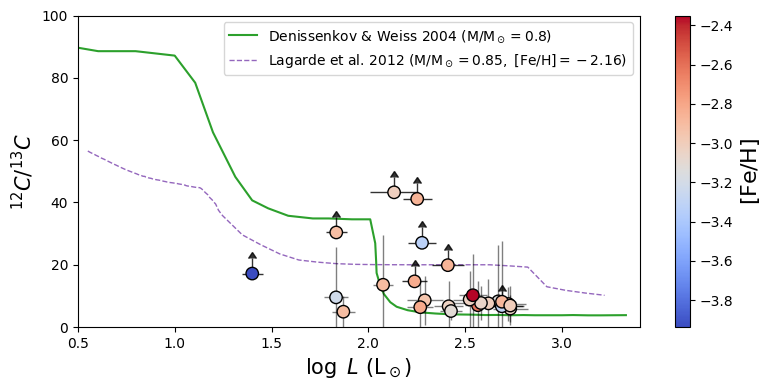

In [408]:
plt.figure(figsize=(8,4), dpi=100)

f_ec = (uves.c1213_ratio.values > 1.5) #(uves.ec12_sme.values < 2.) & (uves.ec13_sme.values < 2.)
plt.scatter(uves.logL.values[f_ec], uves.c1213_ratio.values[f_ec], c=uves.feh.values[f_ec], ec='k', s=80, cmap=plt.cm.coolwarm, zorder=9)
cb = plt.colorbar()
cb.set_label(r'${\rm [Fe/H]}$', size=16)

plt.plot(denissenkov04.logL.values, 10**denissenkov04.logC1213_ratio.values, color='C2', zorder=0, label=r'Denissenkov & Weiss 2004 (${\rm M/M_\odot = 0.8}$)')
plt.plot(np.log10(lagarde['L'].value), lagarde['XC12s'].value/lagarde['XC13s'].value, lw=1, color='C4', ls='--', label=r'Lagarde et al. 2012 (${\rm M/M_\odot = 0.85},\ {\rm [Fe/H] = -2.16}$)')
plt.legend(loc='upper right', fontsize=10)

f_c_sme = (c1213_sme < 20.)
plt.errorbar(uves.logL.values[f_ec & f_c_sme], uves.c1213_ratio.values[f_ec & f_c_sme], fmt='k.', xerr=uves.elogg_sme.values[f_ec & f_c_sme], 
             yerr=c1213_sme[f_ec & f_c_sme], zorder=8, lw=1, alpha=0.5)
plt.errorbar(uves.logL.values[f_ec & ~f_c_sme], uves.c1213_ratio.values[f_ec & ~f_c_sme], fmt='k.', xerr=uves.elogg_sme.values[f_ec & ~f_c_sme], 
             yerr=5*np.ones_like(c1213_sme)[f_ec & ~f_c_sme], zorder=8, lolims=np.ones_like(c1213_sme[f_ec & ~f_c_sme]), lw=1, alpha=0.8)
plt.xlim(0.5, 3.4)
plt.ylim(0, 100)

plt.xlabel(r'$\log\ L\ ({\rm L_\odot})$', size=15)
plt.ylabel(r'$^{12}C/^{13}C$', size=15)

plt.tight_layout()
plt.savefig('plots/Carbon_ratio_logL.pdf', dpi=100)
plt.show()

In [373]:
uves.teff.size

160

In [287]:
uves.query('c1213_ratio > 60 and c1213_ratio < 100').spec_id

2      1738069055902080768_3572805_001
143    6797837428793125760_3573685_105
Name: spec_id, dtype: object

In [164]:
uves[f_ec & f_c_sme].sort_values(by='c1213_ratio', ascending=False)[['spec_id', 'logL', 'c1213_ratio']].head(5)

,spec_id,logL,c1213_ratio
70,6445869192509584640_3573664_098,1.731999,20.861868
3,1749801257286506880_3573721_089,2.410169,18.180794
111,6901832159125681408_3576307_084,1.834115,18.032021
106,6862950683484751616_3572796_029,2.024943,17.002282
102,6846461582481204096_3572822_024,2.011089,16.533975


In [158]:
#Plotting!

In [296]:
spec_id = '6797837428793125760_3573685_105'
sme_c12 = SME_Structure.load('sme_save/UVES_elem_c12_%s.sme' %spec_id)
sme_c13 = SME_Structure.load('sme_save/UVES_elem_c13_%s.sme' %spec_id)

sme = SME_Structure.load('sme_save/UVES_cfe_%s.sme' %spec_id)

[2024-11-14 19:29:59,347] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_elem_c12_6797837428793125760_3573685_105.sme
[2024-11-14 19:29:59,365] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_elem_c13_6797837428793125760_3573685_105.sme
[2024-11-14 19:29:59,384] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_cfe_6797837428793125760_3573685_105.sme


INFO - Loading SME file sme_save/UVES_elem_c12_6797837428793125760_3573685_105.sme
INFO - Loading SME file sme_save/UVES_elem_c13_6797837428793125760_3573685_105.sme
INFO - Loading SME file sme_save/UVES_cfe_6797837428793125760_3573685_105.sme


In [297]:
# sme_c12.abund.update_pattern({'C':uves.c.values[5]})
# sme_c12.vrad_flag = 'None'
# sme_c12.cscale_flag = 'None'
# sme_c13.abund.update_pattern({'C':np.log10((1./15.)*10**(uves.c.values[5]))})
# sme_c13.vrad_flag = 'None'
# sme_c13.cscale_flag = 'None'

# sme_c12 = synthesize_spectrum(sme_c12)
# sme_c13 = synthesize_spectrum(sme_c13)

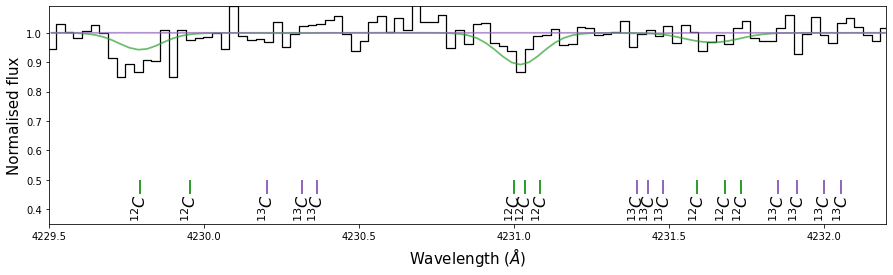

In [299]:
plt.figure(figsize=(15,4))
plt.step(sme.wave.data, sme.spec.data, color='k', lw=1.25, where='mid')
# plt.plot(sme.wave.data, sme.synth.data, color='r', lw=1)
plt.plot(sme_c12.wave.data, sme_c12.synth.data, color='C2', lw=1.75, alpha=0.7)
plt.plot(sme_c13.wave.data, sme_c13.synth.data, color='C4', lw=1.75, alpha=0.7)
# plt.plot(sme_c13.wave.data, 1. - (1. - sme_c12.synth.data) - (1. - sme_c13.synth.data), color='r', lw=1.5, alpha=0.7)

for wline, species, reference in linelist[['wlcent', 'species', 'reference']]:
    if '12' in reference: plt.annotate(text=r'$^{12}C$', xy=(wline - vel_to_AA(sme_c12.vrad)-0.03, 0.37), rotation=90, size=16), plt.vlines(wline - vel_to_AA(sme_c12.vrad), 0.45, 0.5, color='C2', lw=2)
    if '13' in reference: plt.annotate(text=r'$^{13}C$', xy=(wline - vel_to_AA(sme_c13.vrad)-0.03, 0.37), rotation=90, size=16), plt.vlines(wline - vel_to_AA(sme_c13.vrad), 0.45, 0.5, color='C4', lw=2)
    
plt.xlabel(r'Wavelength ($\AA$)', size=15)
plt.ylabel(r'Normalised flux', size=15)

plt.xlim(4229.5, 4232.2)

plt.ylim(0.35, 1.09)
plt.savefig('plots/C12_C13_spec_synthesis.pdf')
plt.show()

In [300]:
sme_c12.fitresults.iterations, sme_c13.fitresults.iterations

(18, 24)

In [301]:
10**(sme_c12.abund.get_element('C')) / 10**(sme_c13.abund.get_element('C'))

66.29333887118666

In [302]:
sme_c12.fitresults.values,sme_c13.fitresults.values

(array([7.76556868]), array([5.94409879]))

In [303]:
sme_c12.fitresults.uncertainties,sme_c13.fitresults.uncertainties

(array([0.56837111]), array([14.12236925]))

In [468]:
from uncertainties import ufloat

In [469]:
c12 = 10**ufloat(sme_c12.fitresults.values, sme_c12.fitresults.uncertainties)
c13 = 10**ufloat(sme_c13.fitresults.values, sme_c13.fitresults.uncertainties)

In [470]:
c12/c13

5.922825210329797+/-4.413902843813197